# SVM

Support Vector Machines (SVM) are powerful and flexible class of supervised algorithms for both classification and regression.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other

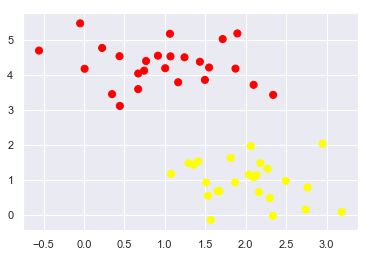

In [7]:
from sklearn.datasets.samples_generator import make_blobs
# n_samples: total number of poins equally divided among clusters, if array-like: each element of the sequence
# indicates the number of samples per cluster
# centers: number of centers to generate
X, y = make_blobs(n_samples=50, centers=2, cluster_std=0.6, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')

For 2D data, drawing a straight line separating the two sets of data seems to be an easy task. But, there is more than one possible dividing line that can perfectly discriminate between the two classes.

(-1, 3.5)

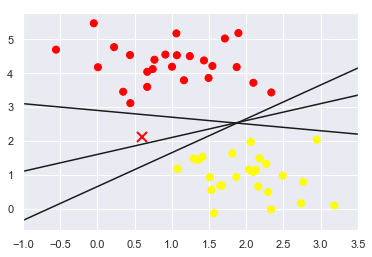

In [8]:
# linspace: returns an array of numbers with start and end
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5)

Above are three different separators which perfectly discriminate between these samples. Depending on which we choose, a new data point will be assigned a different label. So drawing a lin between classes is not enough.

Support vector machines offer one way to improve on this. The intution is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point.

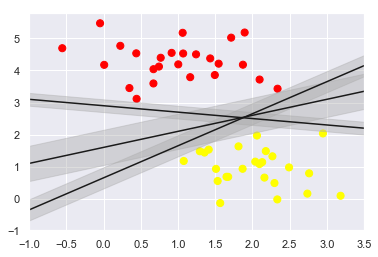

In [9]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. SVM are an example of such an maximum margin estimator.

In [11]:
from sklearn.svm import SVC # support vector classifier
model = SVC(kernel='linear', C = 1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

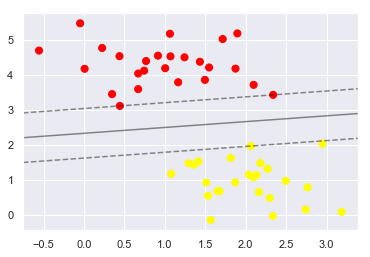

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

In [14]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

## Beyond linear boundaries: Kernel SVM

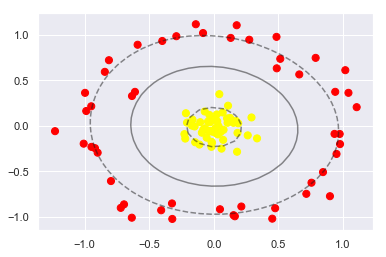

In [23]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='rbf', gamma='auto').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [24]:
r = np.exp(-(X ** 2).sum(1))

In [25]:
from ipywidgets import interact, fixed

from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

## Tuning the SVM: Softening Margins 

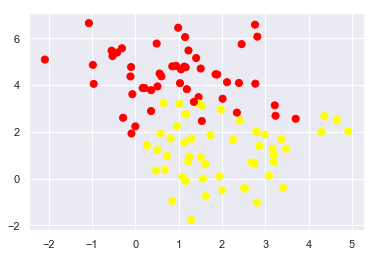

In [26]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:,0], X[:, 1], c=y, s=50, cmap='autumn')

To handle this, we have to tune the value of C. The hardness of the margin is controlled by C. Very large C means the margin is hard and points cannot lie in it. For smaller C the margin is softer and can grow to encompass some points.

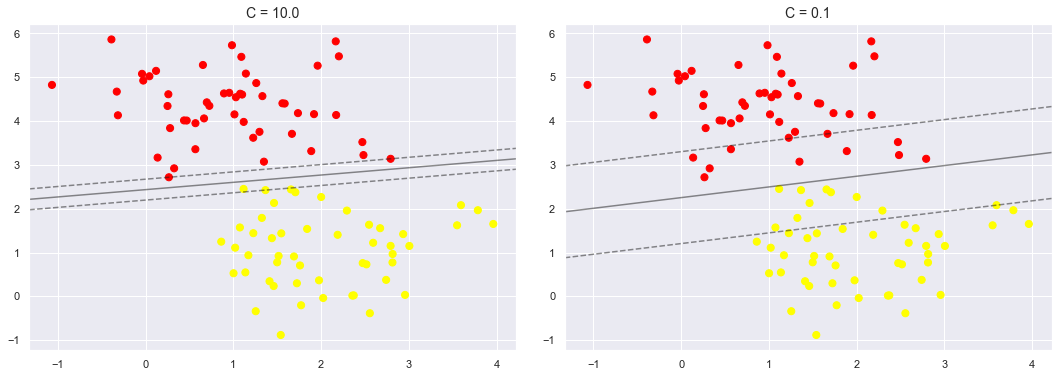

In [27]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)